In [4]:
from statsmodels.api import MNLogit
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
from sklearn import linear_model, tree, neighbors, model_selection
from sklearn.preprocessing import StandardScaler
from patsy import dmatrices
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd

In [6]:
def split(X, y):
    return model_selection.train_test_split(X, y, test_size=.25, random_state=42)

def plot_logit(result, test_data_frame, x_variable):
    plt.subplots()
    ax = plt.plot(test_data_frame[x_variable], result.predict(test_data_frame))
    plt.ylabel(f"Probability of {result.model.endog_names}")
    plt.xlabel("X")
    plt.legend(iter(ax), result.model._ynames_map.values() )

def statsmodels_logistic(y_train, X_train, test_data_frame, x_variable):
    result = MNLogit(y_train, X_train).fit()
    plot_logit(result, test_data_frame, x_variable)

def sklear_logistic(y, X):
    X_train, X_valid, y_train, y_valid = split(X, y)
    result = linear_model.LogisticRegression(C = 1e9).fit(X_train, np.array(y_train).reshape(len(y_train),))
    print("Training accuracy: ", accuracy_score(y_train, result.predict(X_train)))
    print("Training log-loss", log_loss(y_train, result.predict_proba(X_train)))
    print("Validation accuracy: ", accuracy_score(y_valid, result.predict(X_valid)))
    print("Confusion_matrix: \n", confusion_matrix(y_valid, result.predict(X_valid)))

def compare_models(y, X, models, scoring='accuracy'):
    results = []
    for name, model in models.items():
        kfold = model_selection.KFold(n_splits=10, random_state=7)
        cv_results = model_selection.cross_val_score(model, X, y.values.ravel(), cv=kfold, scoring=scoring)
        results.append(cv_results)
        print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(models.keys())

def plot_decision_boudaries(clf, y, X, h=.02):
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        model_selection.train_test_split(X, y, test_size=.4, random_state=42)
    clf.fit(X_train, np.array(y_train).ravel())
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    test = np.c_[ xx.ravel(), yy.ravel() ]
    Z = clf.decision_function(test) if hasattr(clf, "decision_function") else clf.predict_proba(test)[:, 1]
    Z = Z.reshape(xx.shape)
    _, ax = plt.subplots()
    ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.6)
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax.scatter(X_train[:, 0], X_train[:, 1], c=np.array(y_train).ravel(), cmap=cm_bright, edgecolors='k')
    ax.scatter(X_test[:, 0], X_test[:, 1], c=np.array(y_test).ravel(), cmap=cm_bright, edgecolors='k', alpha=0.5)


Optimization terminated successfully.
         Current function value: 0.380195
         Iterations 7
Training accuracy:  0.8133333333333334
Training log-loss 0.3965552158072755
Validation accuracy:  0.87
Confusion_matrix: 
 [[67  4]
 [ 9 20]]
LR: 0.825000 (0.048734)
KNN: 0.842500 (0.043373)
CART: 0.810000 (0.055000)
Optimization terminated successfully.
         Current function value: 1.641472
         Iterations 16
Training accuracy:  0.30333333333333334
Training log-loss 1.6516668822270917
Validation accuracy:  0.26
Confusion_matrix: 
 [[ 0 12  0  0  0  0]
 [ 0 22  4  0  0  0]
 [ 0 23  4  0  0  0]
 [ 0 24  1  0  0  0]
 [ 0  8  0  0  0  0]
 [ 0  1  1  0  0  0]]
LR: 0.250000 (0.071589)
KNN: 0.260000 (0.062450)
CART: 0.250000 (0.067082)


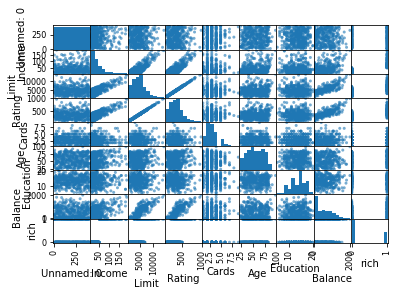

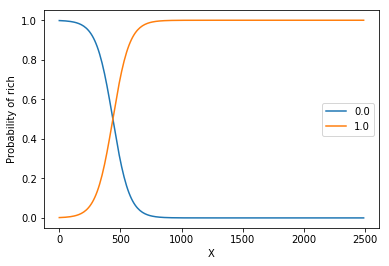

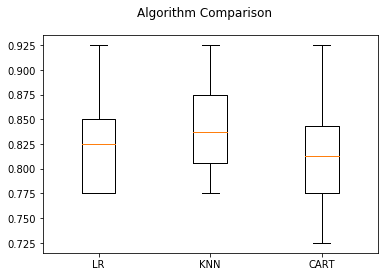

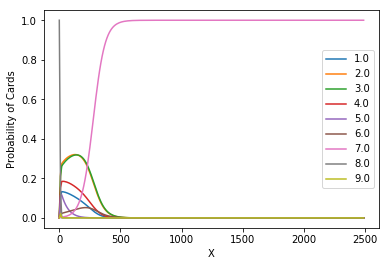

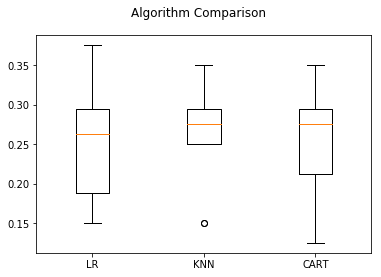

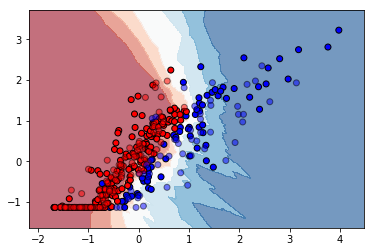

In [7]:
dataset_credit = pd.read_csv('database/Credit.csv').dropna()
df_credit = pd.DataFrame(dataset_credit)
df_credit['rich'] = pd.Series(df_credit['Income'] >= 50, dtype='int')
pd.plotting.scatter_matrix(df_credit, alpha=0.6)
models = \
    {
        'LR': linear_model.LogisticRegression(),
        'KNN': neighbors.KNeighborsClassifier(25),
        'CART': tree.DecisionTreeClassifier(max_depth = 5)
    }

y, X = dmatrices('rich ~ Rating', df_credit, return_type = 'dataframe')
statsmodels_logistic(y, X, pd.DataFrame({'Intercept': 1, 'Rating': np.arange(0, 2500, 10)}), 'Rating')
sklear_logistic(y, X)
compare_models(y, X, models)

y, X = dmatrices('Cards ~ Income', df_credit, return_type = 'dataframe')
statsmodels_logistic(y, X, pd.DataFrame({'Intercept': 1, 'Income': np.arange(0, 2500, 10)}), 'Income')
sklear_logistic(y, X)
compare_models(y, X, models)

y, X = dmatrices('rich ~ Limit + Balance-1', df_credit, return_type = 'dataframe')
X = X.iloc[:, 1:] if len(X.columns) > 2 else X
plot_decision_boudaries(models['KNN'], y, X)
